# Bitcoin Next Day Close Predictor

### Capstone Project
#### Jason Merwin
_______________________________________________________________________________________________________________________________

## Introduction

In this project I will use a machine learning classification model to predict Bitcoin price changes over a 24 hour period. Specifically, an xgboost classifier will use the pattern of previous daily highs to estimate the probability that the next day's highest price will exceed the most recent day's highest price. Such a tool will provide a useful input for short term buy or sell decision of bitcoin holders. The notebook uses three years of historical bitcoin data stored as a 63 kb csv file and an API call to *Alternative Me* for the daily Fear and Greed values during the same time period. Other technical indicators are generated from the base dataset.

_______________________________________________________________________________________________________________________________

First we need to install packages and import the required libraries

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ta
!{sys.executable} -m pip install xgboost --user pip
!{sys.executable} -m pip install imblearn --user pip


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import itertools
import re

import requests
import json

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import numpy as np; np.random.seed(0)
pd.set_option('display.float_format', '{:.3f}'.format)
import seaborn as sns; sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

import ta

## Load Data and Calculate Technical Indicators

Three year of Bitcoin data was downloaded as a csv file from *Yahoo Finance* (https://finance.yahoo.com/cryptocurrencies/) which is free. A historical data set of Fear and Greed Index daily values is downloaded as an API call from *Alternative Me* (https://api.alternative.me/fng). The Fear And Greed Index is computed by analysis of investor emotion and sentiment from a variety of sources. The ta library is used to compute the technical indicators Relative Strength Index (rsi), and the stochastics oscillators stoch_k and stoch_d from the historical data set. 

In [3]:
#load biotcoin daily price historical dataset
BTC_data = pd.read_csv('BTC_USD_2019.csv')

#convert to Pandas dataframe
BTC_df = pd.DataFrame(BTC_data)

#rename date column for merge and change format
BTC_df = BTC_df.rename(columns={'Date': 'timestamp'})
BTC_df['timestamp'] = pd.to_datetime(BTC_df.timestamp, format='%Y-%m-%d')
BTC_df['timestamp'] = BTC_df['timestamp'].dt.strftime('%m-%d-%Y')

#view the dataset
BTC_df

,timestamp,Open,High,Low,Close,Adj Close,Volume
0,01-01-2019,3746.713,3850.914,3707.231,3843.520,3843.520,4324200990
1,01-02-2019,3849.216,3947.981,3817.409,3943.409,3943.409,5244856836
2,01-03-2019,3931.049,3935.685,3826.223,3836.741,3836.741,4530215219
3,01-04-2019,3832.040,3865.935,3783.854,3857.718,3857.718,4847965467
4,01-05-2019,3851.974,3904.903,3836.900,3845.195,3845.195,5137609824
...,...,...,...,...,...,...,...
1178,03-24-2022,42886.652,44131.855,42726.164,43960.934,43960.934,31042992291
1179,03-25-2022,43964.547,44999.492,43706.285,44348.730,44348.730,30574413034
1180,03-26-2022,44349.859,44735.996,44166.273,44500.828,44500.828,16950455995
1181,03-27-2022,44505.355,46827.547,44437.293,46820.492,46820.492,28160889722


In [4]:
#add technical indicators using ta library

# TA's RSI
BTC_df['rsi'] = ta.momentum.rsi(BTC_df.Close)

# TA's Stochastic Oscillator
BTC_df['stoch_k'] = ta.momentum.stoch(BTC_df.High, BTC_df.Low, BTC_df.Close)
BTC_df['stoch_d'] = ta.momentum.stoch_signal(BTC_df.High, BTC_df.Low, BTC_df.Close)

BTC_df

,timestamp,Open,High,Low,Close,Adj Close,Volume,rsi,stoch_k,stoch_d
0,01-01-2019,3746.713,3850.914,3707.231,3843.520,3843.520,4324200990,NaN,NaN,NaN
1,01-02-2019,3849.216,3947.981,3817.409,3943.409,3943.409,5244856836,NaN,NaN,NaN
2,01-03-2019,3931.049,3935.685,3826.223,3836.741,3836.741,4530215219,NaN,NaN,NaN
3,01-04-2019,3832.040,3865.935,3783.854,3857.718,3857.718,4847965467,NaN,NaN,NaN
4,01-05-2019,3851.974,3904.903,3836.900,3845.195,3845.195,5137609824,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1178,03-24-2022,42886.652,44131.855,42726.164,43960.934,43960.934,31042992291,61.337,97.351,93.008
1179,03-25-2022,43964.547,44999.492,43706.285,44348.730,44348.730,30574413034,62.439,91.108,94.734
1180,03-26-2022,44349.859,44735.996,44166.273,44500.828,44500.828,16950455995,62.885,93.186,93.882
1181,03-27-2022,44505.355,46827.547,44437.293,46820.492,46820.492,28160889722,68.950,99.923,94.739


In [5]:
#Use an API call for the Fear and Greed Index historical data from Alternative Me
url = 'https://api.alternative.me/fng/?limit=1200&format=json&date_format=us'

try:
    response = requests.request("GET", url)
except:
    print("An error occurred, try again later.")

jsonResponse = response.json()

#convert response to dataframe
data = jsonResponse["data"]
Fear_Greed_df = pd.DataFrame(data)
Fear_Greed_df

,value,value_classification,timestamp,time_until_update
0,48,Neutral,04-03-2022,-1648913145
1,52,Neutral,04-02-2022,NaN
2,50,Neutral,04-01-2022,NaN
3,52,Neutral,03-31-2022,NaN
4,55,Greed,03-30-2022,NaN
...,...,...,...,...
1195,33,Fear,12-25-2018,NaN
1196,25,Extreme Fear,12-24-2018,NaN
1197,31,Fear,12-23-2018,NaN
1198,28,Fear,12-22-2018,NaN


## Merge, Clean, and Explore Data

In [6]:
#merge the data sets and drop unwanted and empty columns
BTC_data = pd.merge(BTC_df, Fear_Greed_df, on=['timestamp'])
BTC_data = BTC_data.drop(columns=['value_classification', 'time_until_update'])

#find the earliest date in the dataset
min_date = BTC_data['timestamp'].iloc[0]

#create a column from the index indicating the number of days since earliest date in set
BTC_data.reset_index(inplace=True)
BTC_data = BTC_data.rename(columns = {'index':'day_count'})
BTC_data = BTC_data.rename({'value': 'Fear_N_Greed', 'timestamp':'date_format'}, axis=1)

#add numeric values for month, day, week, etc.
BTC_data['date_format'] =  pd.to_datetime(BTC_data['date_format'])
BTC_data['month_numeric'] = BTC_data['date_format'].dt.strftime("%m").astype(int)
BTC_data['weekday_numeric'] = BTC_data['date_format'].dt.dayofweek.astype(int)
BTC_data['week_month_numeric'] = (BTC_data['date_format'].dt.day-1)//7+1
BTC_data['week_year_numeric'] = BTC_data['date_format'].dt.isocalendar().week.astype(int)

#inspect daily highs from dataset
pd.set_option("display.max.columns", None)
pd.set_option("display.precision", 2)
print(BTC_data.tail())

      day_count date_format      Open      High       Low     Close  \
1178       1178  2022-03-24 42886.652 44131.855 42726.164 43960.934   
1179       1179  2022-03-25 43964.547 44999.492 43706.285 44348.730   
1180       1180  2022-03-26 44349.859 44735.996 44166.273 44500.828   
1181       1181  2022-03-27 44505.355 46827.547 44437.293 46820.492   
1182       1182  2022-03-28 46821.852 48086.836 46690.203 47128.004   

      Adj Close       Volume    rsi  stoch_k  stoch_d Fear_N_Greed  \
1178  43960.934  31042992291 61.337   97.351   93.008           40   
1179  44348.730  30574413034 62.439   91.108   94.734           47   
1180  44500.828  16950455995 62.885   93.186   93.882           51   
1181  46820.492  28160889722 68.950   99.923   94.739           49   
1182  47128.004  36362175703 69.658   90.193   94.434           60   

      month_numeric  weekday_numeric  week_month_numeric  week_year_numeric  
1178              3                3                   4                 1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   day_count           1183 non-null   int64         
 1   date_format         1183 non-null   datetime64[ns]
 2   Open                1183 non-null   float64       
 3   High                1183 non-null   float64       
 4   Low                 1183 non-null   float64       
 5   Close               1183 non-null   float64       
 6   Adj Close           1183 non-null   float64       
 7   Volume              1183 non-null   int64         
 8   rsi                 1170 non-null   float64       
 9   stoch_k             1170 non-null   float64       
 10  stoch_d             1168 non-null   float64       
 11  Fear_N_Greed        1183 non-null   object        
 12  month_numeric       1183 non-null   int32         
 13  weekday_numeric     1183 non-null   int32       

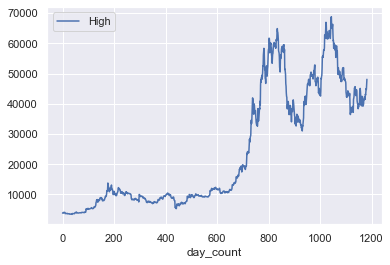

In [7]:
#Explore dataset
print(BTC_data.info())

BTC_data.plot(x="day_count", y="High")
plt.rcParams['figure.figsize'] = [15, 25]
plt.show()

## Define Functions used in Feature Engineering, Data Visualization, and Model Training

In [8]:
#Functions for Feature Engineering and Optimization

#define accuracy function
def cross_fold_accuracy(X, y):
    '''
    input - 
        X - the features list from training data
        y - the label list from training data
    output - an accuracy score
    '''    
    # define the model
    model = XGBClassifier()
    # evaluate the model
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    # report performance
    #print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    accuracy = mean(n_scores)
    
    return accuracy

def row_transpose(index, rows, BTC_data):
    '''
    input - 
        index - the row number of the dataset to start transposition on
        rows - the number of dates (rows) to transpose into columns and add to the dataframe
        BTC_data - the dataframe upoin which to act
    output - a dataframe with a single row of the transposed dates and the row values of the final date in the series
    '''
    #transpose the daily High column
    High_row = pd.DataFrame(BTC_data['High'].iloc[index-rows:index])
    High_row_T = High_row.transpose()
    High_row_T = High_row_T.reset_index().drop(columns=['index'])

    #isolate the selected row for merging
    row_to_merge = pd.DataFrame(BTC_data.iloc[index-1])
    row_to_merge = row_to_merge.transpose()
    row_to_merge = row_to_merge.reset_index().drop(columns=['High','index'])

    #merge and change the column names
    merged_row = pd.concat([High_row_T, row_to_merge], axis=1)
    for i in range(rows+1):
        merged_row.rename(columns={ merged_row.columns[i-1]: i }, inplace = True)
        merged_row.columns = [*merged_row.columns[:-1], 'week_year_numeric'] 
    
    return merged_row

def iterate_dataframe(starting_index, rows, BTC_data):
    '''
    input - 
        starting_index = scalar value for starting row in dataframe, 
        rows = number of days (rows) prior to index to transpose, 
        BTC_data = dataset
    output - transposed row values as columns
    '''
    #set the parameters
    #print('iterating over rows...')
    total_rows = len(BTC_data.index)
    row_increase = 0

    #Get first row
    result = row_transpose(starting_index, rows, BTC_data)

    #transpose rows
    for i in range(starting_index,total_rows):
        row_increase = row_increase+1
        inter_results = row_transpose(starting_index+row_increase, rows, BTC_data)
        result = result.append(inter_results)
        
    #rename transposed columns    
    result = create_label(starting_index, rows, result)
    result.rename(columns = {'Day_0':'week_numeric'}, inplace = True)
     
    return result

def generate_lists(df):
    '''
    input - Dataset containing features and label identified as 'Label'
    output - 'labels' = Label list, 'features' = Features list, 'feature_list' = and a list of feature names
    '''
    #generate the labels and the features
    labels = np.array(df['Label'])
    features = df.drop('Label', axis = 1)

    # Saving feature names as list
    feature_list = list(features.columns)

    # Convert features to array
    features = np.array(features)
    
    return labels, features, feature_list

def create_label(index, rows, df):
    '''
    input - 
        index - the row number to start transposition on
        rows - the number of dates to transpose as columns and the dataframe
        df - the dataframe upoin which to act
    output - a dataframe with the final daily high value removed, repalced with a label column
    '''
    #replace row names
    for i in range(rows+1):
        row_name = 'Day_' + str(i)
        df.rename(columns={ df.columns[i-1]: row_name }, inplace = True)
        
    #drop final day and create label
    untimate_col = 'Day_' + str(rows)
    penultimat_col = 'Day_' + str((rows-1))
    df['Pre_Label'] = df[untimate_col] - df[penultimat_col]

    df.loc[df['Pre_Label'] <= 0, 'Label'] = 0 
    df.loc[df['Pre_Label'] > 0, 'Label'] = 1 

    #clean up NAs and auxiliary columns
    df = df.drop(columns=['Pre_Label', untimate_col])
    df = df.dropna()
        
    return df

def SMA(data, period=30, column='High'):
    '''
    input - 
        data - dataset containing historical daily prices
        period - the number of days for which to calculate the moving average
        column - the name of the column containing the value to be averaged
    output - the simple moving average for the indicated period (days)
    '''
    return data[column].rolling(window=period).mean()

def SMA_minor_major(minor_SMA, major_SMA, data):
    '''
    input - 
        minor_SMA - the number of days from which the smalled SMA will be calculated
        major_SMA - the number of days from which the larger SMA will be calculated
        data - dataframe containing the historical price information
    output - the input dataframe with simple moving average columns added for the indicated days
    '''
    #add the 10 and 50 day
    data['minor_SMA'] = SMA(data, minor_SMA)
    data['major_SMA'] = SMA(data, major_SMA)

    # Get buy and sell signals
    data['Signal'] = np.where(data['minor_SMA'] > data['major_SMA'], 1, 0)
    data['Signal_vol'] = data['minor_SMA'] - data['major_SMA']
    return data

def prep_for_ml(prepared_data, data_SMA_df, total_days=400):
    '''
    input - 
        prepared_data - a dataframe containing the features including the transposed rows as previous day high column values
        data_SMA_df - a dataframe containing the calculated SMA values
        total_days - value indicating the number of rows counted from the end to include in the output dataframe
    output - a merged data set containing all the features and label needed for model training
    '''
    #merge on the date
    merged_data = prepared_data.merge(data_SMA_df, left_on='date_format', right_on='date_format', suffixes=('', '_y'))
    #clean up the columns and NAs
    merged_data.drop(columns=['High', 'date_format', 'day_count_y', 'Open_y', 'Low_y', 'Close_y', 'Adj Close_y', 'Volume_y',
                          'rsi_y', 'stoch_k_y', 'stoch_d_y', 'Fear_N_Greed_y', 'month_numeric_y', 'weekday_numeric_y',
                          'week_month_numeric_y', 'minor_SMA_y', 'major_SMA_y', 'Signal_y'
                         ], inplace=True)
    #drop the na rows
    data_clean = merged_data.dropna()
    #take the most recent days (default = 400)
    data_clean = data_clean.tail(total_days)
    return data_clean

def makeBoxPlot(final_list, x_values):
    '''
    input - 
        final_list - list of accuracy values to average in the plot
        x_values - a list of the parameter values used to generate each set of scores
    output - print a boxplot of the average accuracy per parameter value
    '''
    #set figure dimensions
    fig = plt.figure(figsize = (10, 7))
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    #define x scale
    x_values.insert(0, 0)
    x_scale = list(range(len(x_values)))
    # Creating plot
    bp = ax.boxplot(final_list)
    #replace x axis
    plt.xticks(x_scale, x_values)
    # show plot
    plt.show()

def find_accuracy(model, test_features, test_labels):
    '''
    input - 
        model - a classification Model
        test_features - a list of the test features
        test_labels - a list of the test labels
    output - Accuracy score of the model generated from predictions on the test data
    '''
    prediction_class = []
    threshold = .5
    # Use the forest's predict method on the test data
    predictions = model.predict(test_features)

    for n in predictions:
        if n >= threshold:
            pred = 1
        else:
            pred = 0
        prediction_class.append(pred)
        
    test_results = pd.DataFrame(test_labels, columns =['Test_Label'])
    test_results['Predictions'] = prediction_class
    test_results['Score'] = np.where(test_results['Test_Label'] == test_results['Predictions'],1,0)
    accuracy = test_results['Score'].mean()
    
    return accuracy

### OPTIMIZING DAY CLOSE COLUMNS

This model uses a set number of historical daily high values for bitcoin preceding identify patterns associated and increase in the daily price high the next day. In order to determine the optimal number of historical observations for pattern recognition, the model iterated through a range of days to include from 2 to 45, taking the average of 5 separate model accuracy scores. A box plot of the average accuracy score per number of historical days is used to identify the optimal number. Completing all 45 iterations takes a while, feel free to lower the number of repetitions from 5 to 3 in the inner loop to speed it up, you will still get the same results.

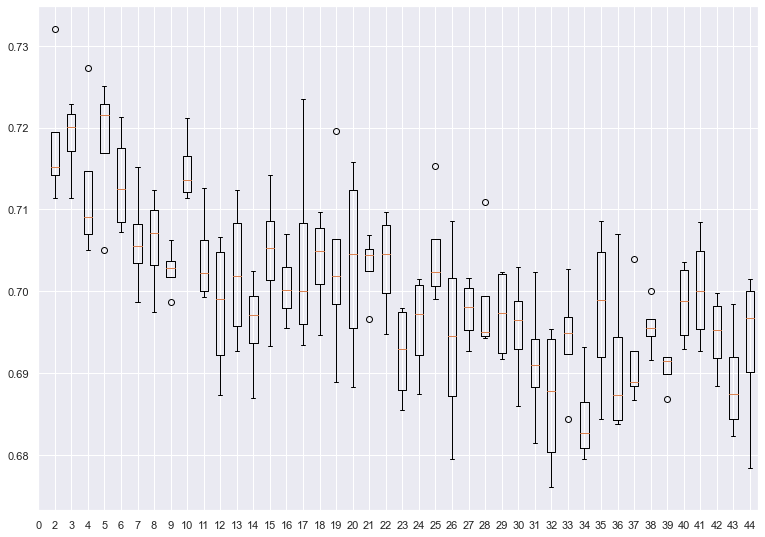

In [10]:
final_list = []
i_values = []

for i in range(2,45):
    
    rows = i
    starting_index = i+1
    accuracy_list = []
    print('i = ', i, end="\r") 
    i_values.append(i)
    
    for m in range(1,5):
        
        prepared_data = iterate_dataframe(starting_index, rows, BTC_data)
        
        #drop the timestamp column
        prepared_data = prepared_data.drop(columns=['date_format'])
        
        labels, features, feature_list = generate_lists(prepared_data)
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.1)

        accuracy = cross_fold_accuracy(train_features, train_labels)
        #print('accuracy', accuracy)
        accuracy_list.append(accuracy)
        
    final_list.append(accuracy_list)

#visualize the results
makeBoxPlot(final_list, i_values)

The accuracy box plot indicates that a surprisingly small range of daily highs, between 3 and 5, produces the best accuracy for price prediction of approximately 0.73. Increasing the number of daily highs above 4 causes the accuracy to progressively decline until about 30 days, at which point it stabilizes and oscillated between around 0.68 and 0.7. Using this information we will proceed with a daily observations value of 4.

In [11]:
#prep the optinized number of day columns
prepared_data = iterate_dataframe(6, 5, BTC_data)
prepared_data

,Day_1,Day_2,Day_3,Day_4,day_count,date_format,Open,Low,Close,Adj Close,Volume,rsi,stoch_k,stoch_d,Fear_N_Greed,month_numeric,weekday_numeric,week_month_numeric,week_numeric,Label
0,3698.978,3674.760,3727.836,3720.153,15,2019-01-16,3631.510,3624.673,3655.007,3655.007,5394457145,40.308,19.514,21.093,24,1,2,3,3,0.000
0,3674.760,3727.836,3720.153,3685.777,16,2019-01-17,3651.871,3621.961,3678.564,3678.564,5464420383,42.144,23.691,19.469,28,1,3,3,3,0.000
0,3727.836,3720.153,3685.777,3680.136,17,2019-01-18,3677.990,3637.081,3657.839,3657.839,5002961727,40.950,20.017,21.074,29,1,4,3,3,1.000
0,3720.153,3685.777,3680.136,3682.520,18,2019-01-19,3652.378,3652.378,3728.568,3728.568,5955691380,46.517,32.555,25.421,31,1,5,3,3,1.000
0,3685.777,3680.136,3682.520,3758.533,19,2019-01-20,3725.446,3583.020,3601.014,3601.014,5582489560,39.318,9.943,20.838,35,1,6,3,3,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,42241.164,41454.410,43124.707,42893.508,1178,2022-03-24,42886.652,42726.164,43960.934,43960.934,31042992291,61.337,97.351,93.008,40,3,3,4,12,1.000
0,41454.410,43124.707,42893.508,44131.855,1179,2022-03-25,43964.547,43706.285,44348.730,44348.730,30574413034,62.439,91.108,94.734,47,3,4,4,12,1.000
0,43124.707,42893.508,44131.855,44999.492,1180,2022-03-26,44349.859,44166.273,44500.828,44500.828,16950455995,62.885,93.186,93.882,51,3,5,4,12,0.000
0,42893.508,44131.855,44999.492,44735.996,1181,2022-03-27,44505.355,44437.293,46820.492,46820.492,28160889722,68.950,99.923,94.739,49,3,6,4,12,1.000


###OPTIMIZING DATA RANGE

The complete data set after merging, calculating indicators, and removing rows with NAs due to their occurrence before the indicators could be calculated contains around 1000 rows, or a little less than 3 years of historical data. The plot of bitcoin historical daily highs showed that the value of bitcoin experienced a period of explosive growth in 2020 before stabilizing in early 2021. Since the model is using price patterns as input, it is possible that including the period of extended growth will not accurately reflect the current period of oscillating values we have been in since 2021. An iteration of the model through a range of dates to include in the data set was carried out to identify the optimal number of days to include in the training data for maximum accuracy.

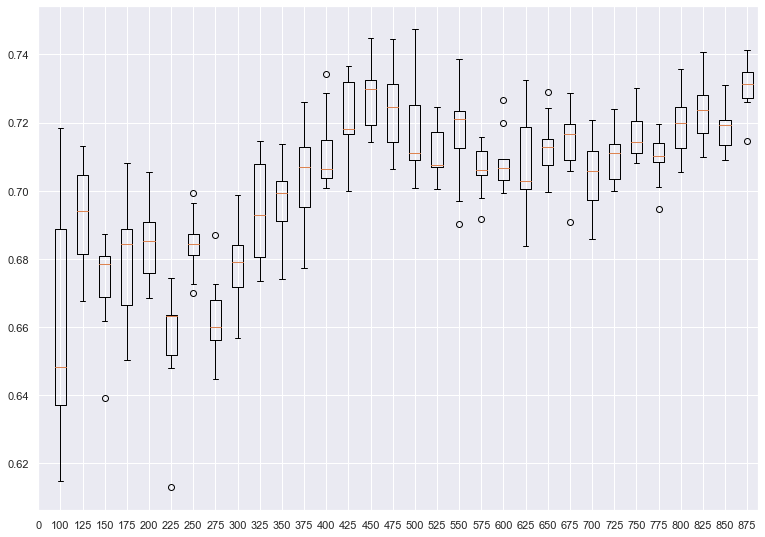

In [18]:
# Optimize the number of days to include in the dataset
data = BTC_data

minor_SMA = 50
major_SMA = 250
final_list = []
x_values = []

# prepare the SMA data for merging
data_SMA = SMA_minor_major(minor_SMA, major_SMA, data)
data_SMA_df = pd.DataFrame(data_SMA)

# iterate dataset
prepared_data = iterate_dataframe(6, 4, BTC_data)

#loop through total_days values and measure accuracy
for x in range(100,900,25):
    x_values.append(x)
    
    data_clean = prep_for_ml(prepared_data, data_SMA_df, total_days=x)

    #run ML on data set and get accuracy
    labels, features, feature_list = generate_lists(data_clean)
    
    #run each 25 times
    accuracy_list = []
    for y in range(1,10):
    
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.1)

        #test accuracy
        accuracy = cross_fold_accuracy(train_features, train_labels)
        accuracy_list.append(accuracy)
        
    final_list.append(accuracy_list)
    print (x, end="\r")

#visualize the results
makeBoxPlot(final_list, x_values)

The resulting accuracy plot shows the accuracy of the model is improved by increasing the number of rows above 375 until about 475. Increasing rows beyond 475 causes a slight decrease in accuracy until we reach about 800, when it begins to increase again with increasing number of included rows. Since the largest value of 875 rows gives an accuracy of around 0.73, which is approximately equivalent to the accuracy measured from 450 rows, and 875 is reaching the maximum limit of the dataset, it seems reasonable to select 450 rows as our optimal number moving forward.

### OPTIMIZING SMA RANGES

Simple Moving Averages (SMA) are common technical indicators which help investors predict long term trends in asset value. Typically, SMAs generated from 50, 100, and 200 day histories are used. Since I am calculating the SMAs directly from the historical dataset, I wanted to see if different combinations of SMA produced different levels of accuracy in the model. A similar iterative approach as used as before to test the effect of a range of SMA values on the model accuracy.


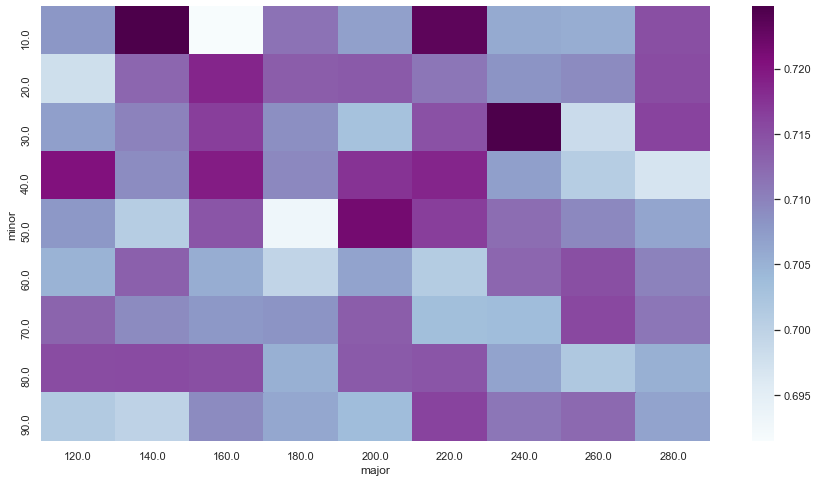

In [62]:
# optimize rolling averages with inner loop 10X sampling
minor = range(10, 100) 
major = range(120, 300) 

accuracy_output = pd.DataFrame(columns = ["minor", "major", "accuracy"])

data = BTC_data

# iterate dataset
prepared_data = iterate_dataframe(6, 4, BTC_data)

for i in range(minor[0], minor[-1]+1, 10):
    
    for j in range(major[0], major[-1]+1, 20):
    
        minor_SMA = i
        major_SMA = j
        accuracy_list = []
            
        # prepare the SMA data
        data_SMA = SMA_minor_major(minor_SMA, major_SMA, data)

        data_SMA_df = pd.DataFrame(data_SMA)

        data_clean = prep_for_ml(prepared_data, data_SMA_df, total_days=400)
        
        labels, features, feature_list = generate_lists(data_clean)

        #inner loop to average 10 runs
        for x in range(1,5):
            
            #run ML on data set and get accuracy
            train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.1)
            accuracy = cross_fold_accuracy(train_features, train_labels)
            accuracy_list.append(accuracy)
        
        row = [i, j, mean(accuracy_list)]
        
        accuracy_output.loc[len(accuracy_output)] = row
        print (i,j, end="\r")

accuracy_map = accuracy_output.pivot('minor', 'major', 'accuracy')
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(accuracy_map, cmap="BuPu")


The heatmap appears to be an essentially random distribution of scores across the combinations tested, thus the standard 50 and 200 will be used for the SMAs. Finally, it is a good idea to check the feature importance to see if there are any features in the model that are not contributing to it's accuracy. It also provides useful insights about the training dataset.

### FEATURE IMPORTANCE

[10:15:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


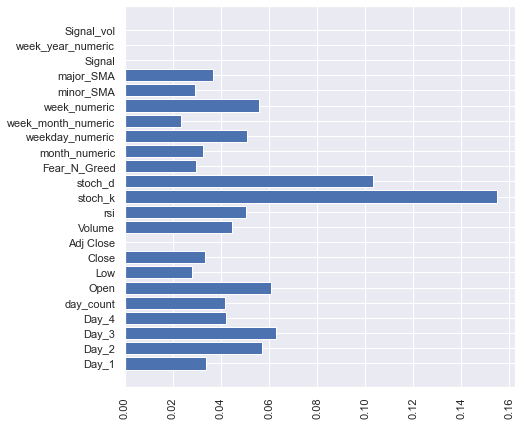

In [21]:
# plot feature importance 

data = BTC_data
# prepare the SMA data for merging
data_SMA = SMA_minor_major(50, 250, data)
data_SMA_df = pd.DataFrame(data_SMA)
# iterate dataset
prepared_data = iterate_dataframe(6, 5, BTC_data)
data_clean = prep_for_ml(prepared_data, data_SMA_df, total_days=450)
labels, features, feature_list = generate_lists(data_clean)
#generate training and testing datasets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.1)
#build list of feature names
data_clean_no_label = data_clean.drop(columns='Label')


# fit model no training data
model = XGBClassifier()

model.fit(train_features, train_labels)
# feature importance
importances = model.feature_importances_
feature_names = data_clean_no_label.columns
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

# plot
#pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.barh(feature_importances['feature'], feature_importances['importance'])
plt.xticks(rotation = 90)

plt.rcParams['figure.figsize'] = [7, 7]

pyplot.show()


### MODEL OPTIMIZATION

In [12]:
#make a copy of the original BTC dataset
data = BTC_data

# prepare the SMA data for merging
data_SMA = SMA_minor_major(50, 200, data)
data_SMA_df = pd.DataFrame(data_SMA)

# generate columns, merge, and prepare for model training
prepared_data = iterate_dataframe(6, 5, BTC_data)
data_clean = prep_for_ml(prepared_data, data_SMA_df, total_days=450)
labels, features, feature_list = generate_lists(data_clean)

#generate training and testing datasets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.1)

#set up pipeline
pipe = Pipeline([
                 ('scl', StandardScaler()),
                 ('m', XGBClassifier())
                ])

#define the parameter ranges as grid
param_grid = {
    "m__n_estimators": range(25,100,25),
    'm__max_depth':range(3,10,2),
    'm__min_child_weight':range(1,6,2),
    'm__subsample':[i/10.0 for i in range(6,10)],
    'm__colsample_bytree':[i/10.0 for i in range(6,10)],
    'm__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100] 
}

#Instantiate the cross validation grid serach
gs_cv = GridSearchCV(estimator=pipe,
                     param_grid=param_grid,
                     n_jobs=-1)

#fit the model
gs_cv.fit(train_features, train_labels)

#report accuracy and optimal parameter values
print("Best parameter (CV score=%0.3f):" % gs_cv.best_score_)
print(gs_cv.best_params_)

#capture optimized parameters
colsample_bytree = gs_cv.best_params_["m__colsample_bytree"]
max_depth = gs_cv.best_params_["m__max_depth"]
min_child_weight = gs_cv.best_params_["m__min_child_weight"]
n_estimators = gs_cv.best_params_["m__n_estimators"]
reg_alpha = gs_cv.best_params_["m__reg_alpha"]
subsample = gs_cv.best_params_["m__subsample"]


[10:05:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameter (CV score=0.764):
{'m__colsample_bytree': 0.8, 'm__max_depth': 7, 'm__min_child_weight': 3, 'm__n_estimators': 75, 'm__reg_alpha': 0.01, 'm__subsample': 0.7}


Optimization of the model improved it's accuracy from around 0.725 to 0.764. Note that dropping the columns shown to have zero feature importance prior to optimization resulted in a decrease in accuracy (data not shown).

### Conclusion
The goal of this project was to train a classification model to recognize patterns in daily bitcoin price history that predict an increase in the next daily high value. An XG-Boost model was used, demonstrating an accuracy of 0.77 after optimization. Several features of the data set were investigated, illustrating some interesting insights regarding accuracy. 

Exploration of the dataset features revealed there were optimal numbers of data to include in the model within narrow ranges of values. For example, accuracy box plots indicated that a including a surprisingly small range of daily highs, between 3 and 5, produces the best accuracy for price prediction. Increasing the number of daily highs included above 5 caused the accuracy to progressively decline until about 30 days, at which point it stabilized and oscillated between around 0.68 and 0.7. 

A similar small optimal range was found for the number of days of historical data to include. Accuracy increased with increasing number of days until 450, at which point increasing the number of days caused accuracy to decline. This is likely because 450 days of history corresponds to the beginning of 2021 when bitcoin prices ended a phase of explosive growth, thus including data from the growth period prior to that date confuses the model.

The number of days used for computing the pair of simple moving averages included in the training data does not appear to have an obvious trend on the model's performance. A heatmap showing the model's accuracy across a range of combinations of days used for a smaller moving average and the large moving average (refered to in this study as minor and major, respectfully) appeared essentially random. Repeating the grid multiple times and with greater number of runs per pair confirmed the lack of correlation between accuracy and a given pair's number of days. 

### Potential Applications of This Study

The daily predictions from this model could provide useful input to short-term buy and sell decisions for Bitcoin traders. Knowing if tomorrow high will be greater than todays with 75% accuracy could help shape short-term hold or sell strategies. The insights derived from the exploration of the data and model performance described above could be useful considerations when building other market prediction algorithms.

### Future Work

The model's performance could potentially be improved by using different algorithms or by using multiple individually optimized algorithms together as an ensemble model. Additionally, while the output of this model is binary, the prediction itself is a probability between 0 and 1 which could potentially be calibrated with historical data to give an idea of prediction confidence and amplitude of the price movement.


### References
BTC historical data API (Free): https://www.yahoofinanceapi.com/ <br>
Alternative Me Fear and Greed API (Free): https://api.alternative.me/ <br>
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ <br>
https://www.machinelearningplus.com/plots/python-boxplot/ <br>
https://www.journaldev.com/32984/numpy-matrix-transpose-array <br>
https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/ <br>
https://medium.com/data-folks-indonesia/simple-moving-average-sma-indicator-using-machine-learning-e8951f61dd9b <br>
